In [1]:
import random, json
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

# Centralized config
from config import (
    RAW_DATA_DIR,
    EXP_DIR_ROOT,
    SEED,
    VAL_RATIO,
    TEST_RATIO,
    BATCH_SIZE,
    EPOCHS,
    LR,
    DEVICE,
    EARLY_STOPPING_PATIENCE,
    EARLY_STOPPING_DELTA,
    DROPOUT,
    FREEZE_UNTIL_LAYER,
    NUM_WORKERS
)


r:\MUL\Courses\Applied ML\raman-mineral-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = DEVICE
print(f"Device in use: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Device in use: cuda
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
class RamanDataset(Dataset):
    def __init__(self, fps_label, split="train"):
        rows = []

        for mineral_dir in RAW_DATA_DIR.iterdir():
            if not mineral_dir.is_dir():
                continue

            fps_dir = mineral_dir / fps_label
            if not fps_dir.exists():
                continue

            images = sorted(fps_dir.glob("*.bmp"))

            train_val, test = train_test_split(
                images, test_size=TEST_RATIO, random_state=SEED
            )
            train, val = train_test_split(
                train_val,
                test_size=VAL_RATIO / (1 - TEST_RATIO),
                random_state=SEED
            )

            split_map = {"train": train, "val": val, "test": test}

            for img in split_map[split]:
                rows.append({
                    "path": img,
                    "label": mineral_dir.name
                })

        self.df = pd.DataFrame(rows)
        self.labels = sorted(self.df.label.unique())
        self.label_map = {l: i for i, l in enumerate(self.labels)}

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        img = self.transform(img)
        label = self.label_map[row.label]
        return img, label


In [8]:
def train_resnet(fps_label):

    print("\n===================================================")
    print(f"🚀 Training ResNet18 | FPS = {fps_label}")
    print("===================================================")

    # --------------------------------------------------
    # EXPERIMENT DIR
    # --------------------------------------------------
    EXP_DIR = EXP_DIR_ROOT / "resnet" / fps_label
    EXP_DIR.mkdir(parents=True, exist_ok=True)

    MODEL_PATH = EXP_DIR / "resnet.pt"
    METRICS_PATH = EXP_DIR / "metrics.json"

    # --------------------------------------------------
    # DATASETS
    # --------------------------------------------------
    train_ds = RamanDataset(fps_label, split="train")
    val_ds   = RamanDataset(fps_label, split="val")
    test_ds  = RamanDataset(fps_label, split="test")

    num_classes = len(np.unique(train_ds.labels))

    print(
        f"Samples → Train: {len(train_ds)} | "
        f"Val: {len(val_ds)} | "
        f"Test: {len(test_ds)} | "
        f"Classes: {num_classes}"
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_ds,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    # --------------------------------------------------
    # MODEL
    # --------------------------------------------------
    model = models.resnet18(
        weights=models.ResNet18_Weights.IMAGENET1K_V1
    )

    # Freeze early layers (freeze=1 behaviour)
    for name, param in model.named_parameters():
        if name.startswith(("conv1", "bn1", "layer1")):
            param.requires_grad = False

    model.fc = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(model.fc.in_features, num_classes)
    )

    model = model.to(device)

    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR
    )

    criterion = nn.CrossEntropyLoss()

    history = []
    best_val_acc = 0.0

    # --------------------------------------------------
    # TRAINING LOOP
    # --------------------------------------------------
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        model.train()
        train_loss = 0.0

        for x, y in tqdm(train_loader, desc="Training", leave=False):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # ---------------- VALIDATION ----------------
        model.eval()
        correct, total = 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x).argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        val_acc = correct / total

        history.append({
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "val_accuracy": val_acc
        })

        print(
            f"Train Loss: {train_loss:.4f} | "
            f"Val Accuracy: {val_acc:.4f}"
        )

        # ---------------- SAVE BEST ----------------
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"✔ Best model saved → {MODEL_PATH}")

    # --------------------------------------------------
    # TEST
    # --------------------------------------------------
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            correct += (model(x).argmax(1) == y).sum().item()
            total += y.size(0)

    test_acc = correct / total

    print(f"\n✅ TEST ACCURACY ({fps_label}): {test_acc:.4f}")

    # --------------------------------------------------
    # SAVE METRICS
    # --------------------------------------------------
    with open(METRICS_PATH, "w") as f:
        json.dump({
            "fps": fps_label,
            "num_classes": num_classes,
            "best_val_accuracy": best_val_acc,
            "test_accuracy": test_acc,
            "history": history
        }, f, indent=2)

    print(f"📁 Metrics saved → {METRICS_PATH}")

    return test_acc


In [9]:
acc_1fps = train_resnet("1fps")
acc_30fps = train_resnet("30fps")

print("\n==============================")
print("FINAL RESULTS")
print("==============================")
print(f"1 FPS  Test Accuracy : {acc_1fps:.4f}")
print(f"30 FPS Test Accuracy : {acc_30fps:.4f}")



🚀 Training ResNet18 | FPS = 1fps
Samples → Train: 3956 | Val: 496 | Test: 497 | Classes: 7

Epoch 1/5


Train Loss: 0.0302 | Val Accuracy: 1.0000
✔ Best model saved → R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\resnet\1fps\resnet.pt

Epoch 2/5


Train Loss: 0.0004 | Val Accuracy: 1.0000

Epoch 3/5


Train Loss: 0.0001 | Val Accuracy: 1.0000

Epoch 4/5


Train Loss: 0.0001 | Val Accuracy: 1.0000

Epoch 5/5


Train Loss: 0.0001 | Val Accuracy: 1.0000

✅ TEST ACCURACY (1fps): 1.0000
📁 Metrics saved → R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\resnet\1fps\metrics.json

🚀 Training ResNet18 | FPS = 30fps
Samples → Train: 4019 | Val: 505 | Test: 506 | Classes: 7

Epoch 1/5


Train Loss: 0.0375 | Val Accuracy: 1.0000
✔ Best model saved → R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\resnet\30fps\resnet.pt

Epoch 2/5


Train Loss: 0.0002 | Val Accuracy: 1.0000

Epoch 3/5


Train Loss: 0.0441 | Val Accuracy: 1.0000

Epoch 4/5


Train Loss: 0.0072 | Val Accuracy: 1.0000

Epoch 5/5


Train Loss: 0.0005 | Val Accuracy: 1.0000

✅ TEST ACCURACY (30fps): 1.0000
📁 Metrics saved → R:\MUL\Courses\Applied ML\raman-mineral-classification\experiments\resnet\30fps\metrics.json

FINAL RESULTS
1 FPS  Test Accuracy : 1.0000
30 FPS Test Accuracy : 1.0000


Using device: cuda

📌 Evaluating ResNet on 1fps


Testing: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]


✅ Test Accuracy (1fps): 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00        73
     Calcite       1.00      1.00      1.00        69
     Dolomit       1.00      1.00      1.00        71
    Feldspat       1.00      1.00      1.00        72
       Quarz       1.00      1.00      1.00        74
Rhodocrosite       1.00      1.00      1.00        69
        Tile       1.00      1.00      1.00        69

    accuracy                           1.00       497
   macro avg       1.00      1.00      1.00       497
weighted avg       1.00      1.00      1.00       497



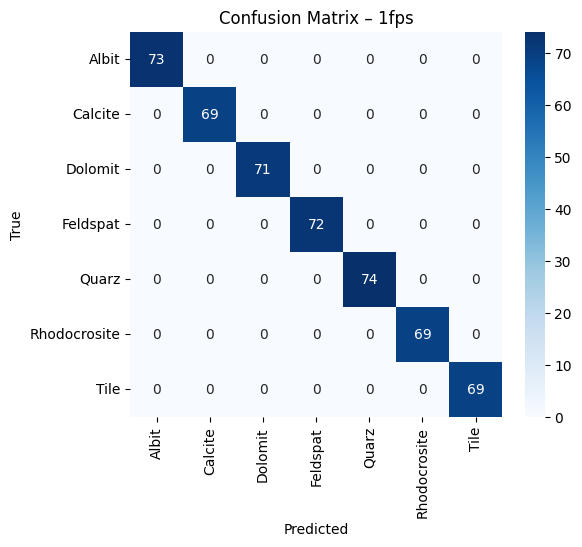


📌 Evaluating ResNet on 30fps


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]


✅ Test Accuracy (30fps): 1.0000

📄 Classification Report:
              precision    recall  f1-score   support

       Albit       1.00      1.00      1.00        72
     Calcite       1.00      1.00      1.00        61
     Dolomit       1.00      1.00      1.00        77
    Feldspat       1.00      1.00      1.00        76
       Quarz       1.00      1.00      1.00        74
Rhodocrosite       1.00      1.00      1.00        74
        Tile       1.00      1.00      1.00        72

    accuracy                           1.00       506
   macro avg       1.00      1.00      1.00       506
weighted avg       1.00      1.00      1.00       506



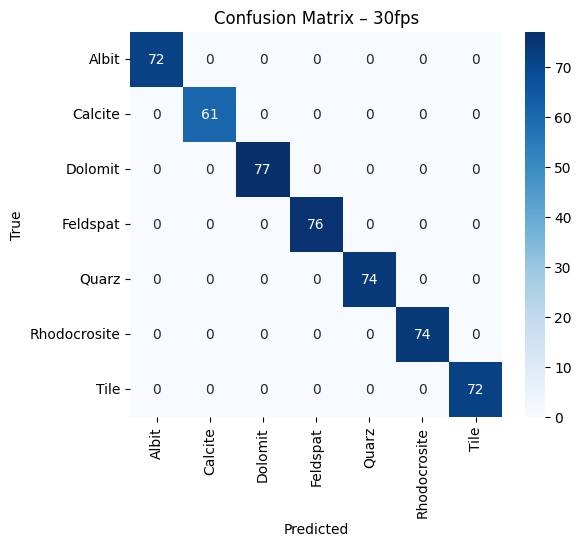


📊 Final Test Accuracies
1 FPS  → 1.0000
30 FPS → 1.0000


In [11]:
# ----------------------------
# Evaluation cell for ResNet
# ----------------------------
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from PIL import Image
from pathlib import Path

# Ensure device matches training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ----------------------------
# Dataset (must match training splits!)
# ----------------------------
class RamanDataset(torch.utils.data.Dataset):
    def __init__(self, fps_label, split="test"):
        rows = []
        for mineral_dir in RAW_DATA_DIR.iterdir():
            if not mineral_dir.is_dir():
                continue
            fps_dir = mineral_dir / fps_label
            if not fps_dir.exists():
                continue
            images = sorted(fps_dir.glob("*.bmp"))
            
            # Split dataset same as training
            from sklearn.model_selection import train_test_split
            train_val, test = train_test_split(images, test_size=TEST_RATIO, random_state=SEED)
            train, val = train_test_split(train_val, test_size=VAL_RATIO / (1 - TEST_RATIO), random_state=SEED)
            
            split_map = {"train": train, "val": val, "test": test}
            for img in split_map[split]:
                rows.append({"path": img, "label": mineral_dir.name})
        
        self.df = pd.DataFrame(rows)
        self.labels = sorted(self.df.label.unique())
        self.label_map = {l: i for i, l in enumerate(self.labels)}
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        img = self.transform(img)
        label = self.label_map[row.label]
        return img, label

# ----------------------------
# Function to load trained ResNet
# ----------------------------
def load_trained_resnet(num_classes, model_path):
    model = models.resnet18(
        weights=models.ResNet18_Weights.IMAGENET1K_V1
    )

    model.fc = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(model.fc.in_features, num_classes)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


# ----------------------------
# Evaluate function
# ----------------------------
def evaluate_model(fps_label):
    print(f"\n📌 Evaluating ResNet on {fps_label}")
    
    test_ds = RamanDataset(fps_label, split="test")
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, pin_memory=True)
    
    model_path = EXP_DIR_ROOT / "resnet" / fps_label / "resnet.pt"
    if not model_path.exists():
        print(f"⚠️ Model not found at {model_path}")
        return None, None
    
    model = load_trained_resnet(len(test_ds.labels), model_path)
    
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc="Testing"):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())
    
    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"✅ Test Accuracy ({fps_label}): {acc:.4f}")
    
    # Classification report
    print("\n📄 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=test_ds.labels, zero_division=0))
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_ds.labels, yticklabels=test_ds.labels, cmap="Blues")
    plt.title(f"Confusion Matrix – {fps_label}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    return acc, cm

# ----------------------------
# Run evaluation for both FPS
# ----------------------------
acc_1fps, cm_1fps = evaluate_model("1fps")
acc_30fps, cm_30fps = evaluate_model("30fps")

print("\n📊 Final Test Accuracies")
print(f"1 FPS  → {acc_1fps:.4f}" if acc_1fps is not None else "1 FPS → Not tested")
print(f"30 FPS → {acc_30fps:.4f}" if acc_30fps is not None else "30 FPS → Not tested")


In [13]:
# ----------------------------
# Save Results to results folder
# ----------------------------
import json
from pathlib import Path
import config
from config import RAW_DATA_DIR, EXP_DIR_ROOT, SEED, VAL_RATIO, TEST_RATIO, BATCH_SIZE, DEVICE
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device(DEVICE)

# Redefine RamanDataset for this cell
class RamanDataset(torch.utils.data.Dataset):
    def __init__(self, fps_label, split="test"):
        rows = []
        for mineral_dir in RAW_DATA_DIR.iterdir():
            if not mineral_dir.is_dir():
                continue
            fps_dir = mineral_dir / fps_label
            if not fps_dir.exists():
                continue
            images = sorted(fps_dir.glob("*.bmp"))
            
            # Split dataset same as training
            from sklearn.model_selection import train_test_split
            train_val, test = train_test_split(images, test_size=TEST_RATIO, random_state=SEED)
            train, val = train_test_split(train_val, test_size=VAL_RATIO / (1 - TEST_RATIO), random_state=SEED)
            
            split_map = {"train": train, "val": val, "test": test}
            for img in split_map[split]:
                rows.append({"path": img, "label": mineral_dir.name})
        
        self.df = pd.DataFrame(rows)
        self.labels = sorted(self.df.label.unique())
        self.label_map = {l: i for i, l in enumerate(self.labels)}
        
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        img = self.transform(img)
        label = self.label_map[row.label]
        return img, label

# Redefine load_trained_resnet for this cell
def load_trained_resnet(num_classes, model_path):
    model = models.resnet18(
        weights=models.ResNet18_Weights.IMAGENET1K_V1
    )

    model.fc = nn.Sequential(
        nn.Dropout(DROPOUT),
        nn.Linear(model.fc.in_features, num_classes)
    )

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


# Create results directory for resnet if it doesn't exist
results_dir = config.RESULTS_DIR / "resnet"
results_dir.mkdir(parents=True, exist_ok=True)

# Function to save results for a given FPS
def save_resnet_results(fps_label, accuracy, cm_matrix, y_true, y_pred, class_labels):
    results = {
        "fps": fps_label,
        "accuracy": float(accuracy),
        "num_test_samples": int(len(y_true)),
        "num_classes": len(class_labels),
        "classes": list(class_labels),
        "confusion_matrix": cm_matrix.tolist()
    }
    
    output_file = results_dir / f"test_results_{fps_label}.json"
    with open(output_file, 'w') as f:
        json.dump(results, f, indent=2)
    
    print(f"✅ Results saved to: {output_file}")
    
    # Save confusion matrix as image
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels,
                cbar_kws={'label': 'Count'})
    plt.title(f"Confusion Matrix – ResNet ({fps_label})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    
    cm_image_file = results_dir / f"confusion_matrix_{fps_label}.png"
    plt.savefig(cm_image_file, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"✅ Confusion matrix image saved to: {cm_image_file}")

# Save results for both FPS settings
print("\n💾 Saving ResNet results to results folder...")

for fps_label in ["1fps", "30fps"]:
    # Get test dataset
    test_ds = RamanDataset(fps_label, split="test")
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, pin_memory=True)
    class_labels = test_ds.labels
    
    # Load model
    model_path = EXP_DIR_ROOT / "resnet" / fps_label / "resnet.pt"
    if not model_path.exists():
        print(f"⚠️ Model not found for {fps_label}, skipping...")
        continue
    
    model = load_trained_resnet(len(test_ds.labels), model_path)
    
    # Get predictions
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate accuracy and confusion matrix
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    # Save
    save_resnet_results(fps_label, acc, cm, y_true, y_pred, class_labels)

print("\n✅ All ResNet results saved successfully!")


💾 Saving ResNet results to results folder...
✅ Results saved to: R:\MUL\Courses\Applied ML\raman-mineral-classification\results\resnet\test_results_1fps.json
✅ Confusion matrix image saved to: R:\MUL\Courses\Applied ML\raman-mineral-classification\results\resnet\confusion_matrix_1fps.png
✅ Results saved to: R:\MUL\Courses\Applied ML\raman-mineral-classification\results\resnet\test_results_30fps.json
✅ Confusion matrix image saved to: R:\MUL\Courses\Applied ML\raman-mineral-classification\results\resnet\confusion_matrix_30fps.png

✅ All ResNet results saved successfully!
